## Segment with a cellpose network

In this notebook we use a default ('cyto2') and custom trained cellpose network on a sample with simulated beads of different size and intensity. 

In [33]:
from skimage.io import imread, imsave
from tnia.plotting.projections import show_xyz_slice, show_xyz_max
from cellpose import models, io
import os
import sys
sys.path.append('../')
import decon_helper as dh
from tnia.plotting.plt_helper import random_label_cmap
colormap=random_label_cmap()

## Load Data

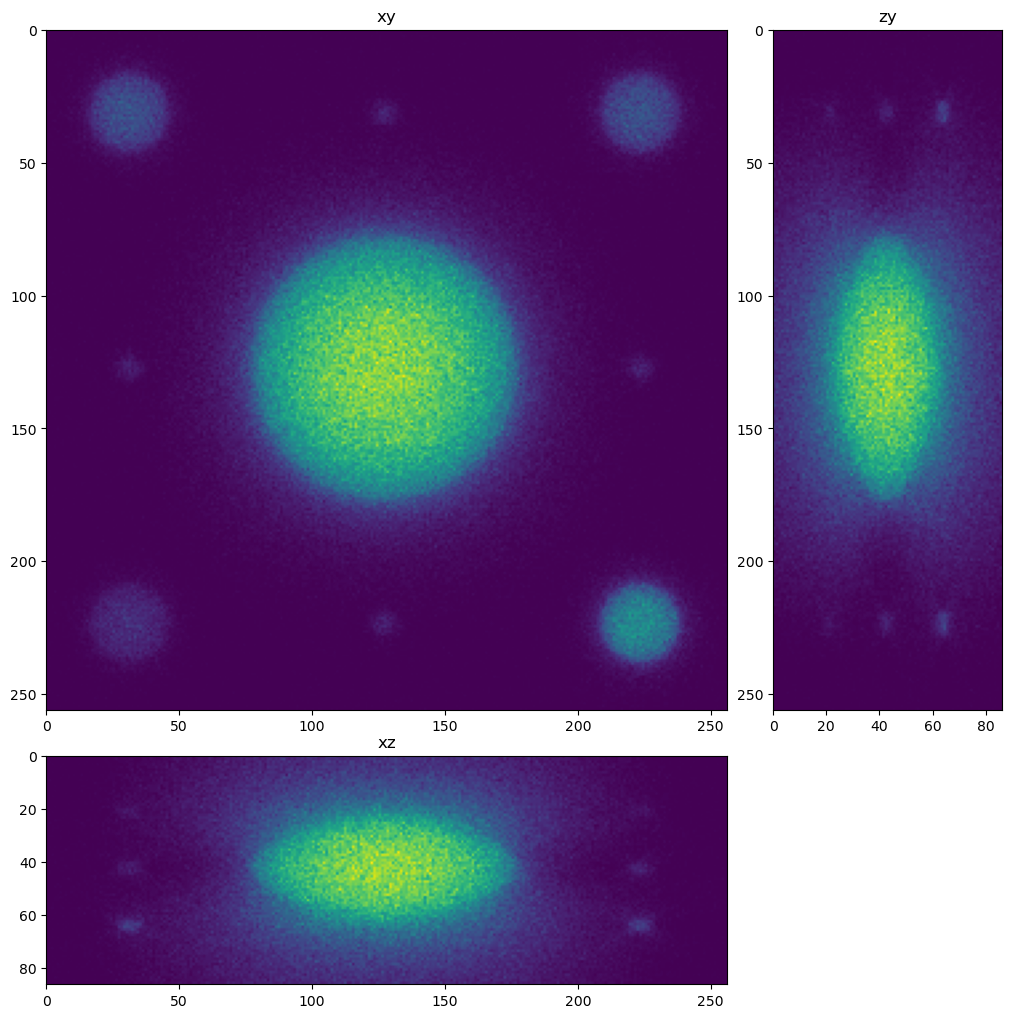

In [34]:
input_names = [r'../../data/deep learning testing/inputs/spheres2.tif']

inputs=[]

for input_name in input_names:
    input = imread(input_name)
    nmin=input.min()
    nmax=input.max()
    input = (input.astype('float32')-nmin) / (nmax - nmin)
    inputs.append(input)
    dh.show_xyz_slice(input, 'tnia')

## Load models

Load the cellpose model that we trained for simulated beads and the cyto2 model.

In [25]:
parent_dl_path = r'../../models'
dl_path = r'../../models'
model_path = os.path.join(parent_dl_path, r'models')
# start logger (to see training across epochs)
logger = io.logger_setup()

models_collection = []
model_names = []

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models','cellpose_try'))
models_collection.append(model)
model_names.append('custom')

model = models.CellposeModel(gpu=True, model_type='cyto2')
models_collection.append(model)
model_names.append('cyto2')
#rint(os.path.join(model_path,'models','cellpose_model1'))

creating new log file
2024-01-20 18:29:26,952 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-01-20 18:29:26,954 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.9.16 
torch version:  	2.1.2+cpu
2024-01-20 18:29:26,955 [INFO] >>>> loading model ../../models\models\models\cellpose_try
2024-01-20 18:29:26,956 [INFO] TORCH CUDA version not installed/working.
2024-01-20 18:29:26,957 [INFO] >>>> using CPU
2024-01-20 18:29:27,086 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-01-20 18:29:27,087 [INFO] >>>> model diam_labels =  15.622 (mean diameter of training ROIs)
2024-01-20 18:29:27,093 [INFO] >> cyto2 << model set to be used
2024-01-20 18:29:27,095 [INFO] TORCH CUDA version not installed/working.
2024-01-20 18:29:27,096 [INFO] >>>> using CPU
2024-01-20 18:29:27,221 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


## Apply each

The below code block is set up to also be able to test different diameters.  Right now I use a diameter of 30 (the diameter the cyto model is reported to have been trained at). 

In [31]:
diameters = [30]

masks = []

for diameter in diameters:
    for model in models_collection:
        mask = model.eval(inputs[0], channels=[0,1,2],diameter=diameter, do_3D=True, anisotropy=3,flow_threshold=0.8, cellprob_threshold=-0.8 )[0]
        #mask = model.eval(inputs[0], channels=[0,1,2], do_3D=True, anisotropy=3,flow_threshold=0.8, cellprob_threshold=-0.8 )[0]
        masks.append(mask)

2024-01-20 18:39:54,068 [INFO] multi-stack tiff read in as having 86 planes 1 channels
2024-01-20 18:39:54,402 [INFO] running YX: 86 planes of size (256, 256)
2024-01-20 18:40:22,711 [INFO] 100%|##########| 11/11 [00:28<00:00,  2.57s/it]
2024-01-20 18:40:22,865 [INFO] running ZY: 256 planes of size (86, 256)
2024-01-20 18:41:43,952 [INFO] 100%|##########| 32/32 [01:21<00:00,  2.53s/it]
2024-01-20 18:41:44,361 [INFO] running ZX: 256 planes of size (86, 256)
2024-01-20 18:43:04,809 [INFO] 100%|##########| 32/32 [01:20<00:00,  2.51s/it]
2024-01-20 18:43:05,100 [INFO] network run in 191.00s
2024-01-20 18:43:06,953 [INFO] masks created in 1.85s
2024-01-20 18:43:07,721 [INFO] multi-stack tiff read in as having 86 planes 1 channels
2024-01-20 18:43:08,047 [INFO] running YX: 86 planes of size (256, 256)
2024-01-20 18:43:36,152 [INFO] 100%|##########| 11/11 [00:28<00:00,  2.55s/it]
2024-01-20 18:43:36,305 [INFO] running ZY: 256 planes of size (86, 256)
2024-01-20 18:44:58,254 [INFO] 100%|######

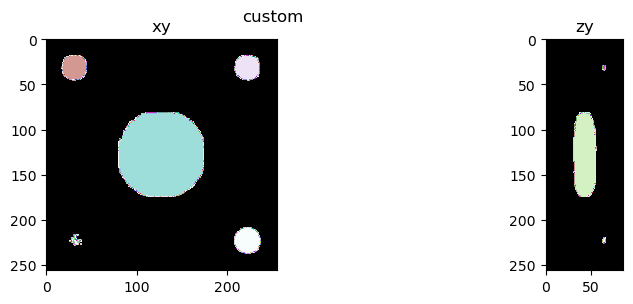

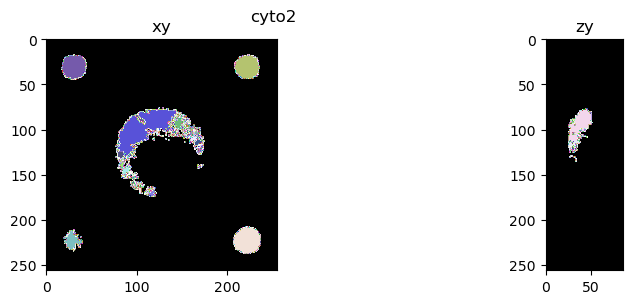

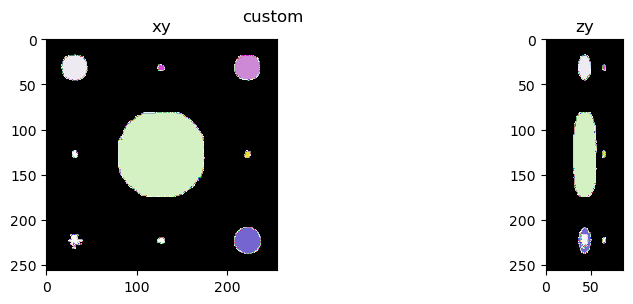

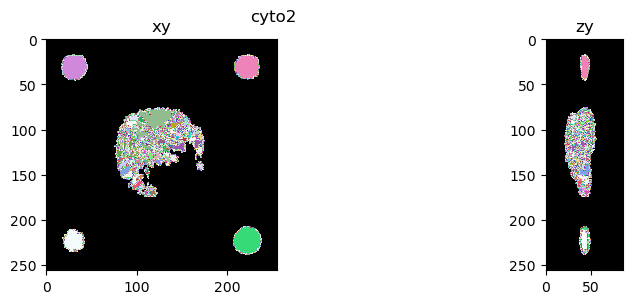

In [36]:
from tnia.plotting.projections import show_xy_zy_slice_center, show_xy_zy_max

for mask, name in zip(masks, model_names):
    fig=show_xy_zy_slice_center(mask, colormap=colormap)
    fig.suptitle(name)

for mask, name in zip(masks, model_names):
    fig=show_xy_zy_max(mask, colormap=colormap)
    fig.suptitle(name)

In [6]:
#diameters = [5, 25, 100, 30]

import napari
viewer = napari.Viewer()
viewer.add_image(inputs[0], name='input')
viewer.add_labels(masks[0], name='mask'+str(diameters[0]))
#viewer.add_labels(masks[1], name='mask'+str(diameters[1]))
#viewer.add_labels(masks[2], name='mask'+str(diameters[2]))
#viewer.add_labels(masks[3], name='mask'+str(diameters[2]))

2024-01-20 17:48:45,466 [ERROR] napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'
2024-01-20 17:48:48,590 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


<Labels layer 'mask30' at 0x198a09933a0>

In [ ]:
print(os.getcwd())
out_path = r"../../outputs/cellpose"

if not os.path.exists(out_path):
    os.makedirs(out_path)

In [ ]:
for mask, diameter in zip(masks, diameters):
    imsave(os.path.join(out_path, 'cellpose_mask'+str(diameter)+'.tif'), mask.astype('uint16'))

In [10]:
help(model.train)

Help on method train in module cellpose.models:

train(train_data, train_labels, train_files=None, test_data=None, test_labels=None, test_files=None, channels=None, normalize=True, save_path=None, save_every=100, save_each=False, learning_rate=0.2, n_epochs=500, momentum=0.9, SGD=True, weight_decay=1e-05, batch_size=8, nimg_per_epoch=None, rescale=True, min_train_masks=5, model_name=None) method of cellpose.models.CellposeModel instance
    train network with images train_data 
    
    Parameters
    ------------------
    
    train_data: list of arrays (2D or 3D)
        images for training
    
    train_labels: list of arrays (2D or 3D)
        labels for train_data, where 0=no masks; 1,2,...=mask labels
        can include flows as additional images
    
    train_files: list of strings
        file names for images in train_data (to save flows for future runs)
    
    test_data: list of arrays (2D or 3D)
        images for testing
    
    test_labels: list of arrays (2D or 3D)